In [4]:
import numpy as np

In [5]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [6]:
import grader

# ML: Predicting Star Ratings

Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a dataset of venue popularities provided by Yelp.  The dataset contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants. This tutorial will walk you through one way to build a machine-learning algorithm.

## Metric

Your model will be assessed based on the root mean squared error of the number of stars you predict.  There is a reference solution (which should not be too hard to beat).  The reference solution has a score of 1. Keeping this in mind...

## A note on scoring
It **is** possible to score >1 on these questions. This indicates that you've beaten our reference model - we compare our model's score on a test set to your score on a test set. See how high you can go!


## Download and parse the incoming data

We start by downloading the dataset from Amazon S3:

In [7]:
!aws s3 sync s3://dataincubator-course/mldata/ . --exclude '*' --include 'yelp_train_academic_dataset_business.json.gz'

The training data are a series of JSON objects, in a gzipped file. Python supports gzipped files natively: [gzip.open](https://docs.python.org/2/library/gzip.html) has the same interface as `open`, but handles `.gz` files automatically.

The built-in json package has a `loads()` function that converts a JSON string into a Python dictionary.  We could call that once for each row of the file. [ujson](http://docs.micropython.org/en/latest/library/ujson.html) has the same interface as the built-in `json` library, but is *substantially* faster (at the cost of non-robust handling of malformed json).  We will use that inside a list comprehension to get a list of dictionaries:

In [8]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [9]:
data[0]

{u'attributes': {u'By Appointment Only': True},
 u'business_id': u'vcNAWiLM4dR7D2nwwJ7nCA',
 u'categories': [u'Doctors', u'Health & Medical'],
 u'city': u'Phoenix',
 u'full_address': u'4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018',
 u'hours': {u'Friday': {u'close': u'17:00', u'open': u'08:00'},
  u'Monday': {u'close': u'17:00', u'open': u'08:00'},
  u'Thursday': {u'close': u'17:00', u'open': u'08:00'},
  u'Tuesday': {u'close': u'17:00', u'open': u'08:00'},
  u'Wednesday': {u'close': u'17:00', u'open': u'08:00'}},
 u'latitude': 33.499313,
 u'longitude': -111.983758,
 u'name': u'Eric Goldberg, MD',
 u'neighborhoods': [],
 u'open': True,
 u'review_count': 7,
 u'stars': 3.5,
 u'state': u'AZ',
 u'type': u'business'}

In [10]:
data[4]['city']

u'De Forest'

In Scikit Learn, the labels to be predicted, in this case, the stars, are always kept in a separate data structure than the features.  Let's get in this habit now, by creating a separate list of the ratings:

In [11]:
star_ratings = [row['stars'] for row in data]

In [12]:
#star_ratings

### Notes:
1. [Pandas](http://pandas.pydata.org/) is able to read JSON text directly.  Use the `read_json()` function with the `lines=True` keyword argument.  While the rest of this notebook will assume you are using a list of dictionaries, you can complete it with dataframes, if you so desire.  Some of the example code will need to be modified in this case.

2. There are obvious miscodings in the data.  There is no need to try to correct them.

## Building models

For many of the questions below, you will need to build and train an estimator that predicts the star rating given certain features.  This could be a custom estimator that you built from scratch, but in most cases will be a pipeline containing custom or prebuilt transformers and an existing estimator.  We will give you hints of how to proceed, but the only requirement for you is to produce a model that does as well, or better, than the reference models we created.  You are welcome to do this however you like. The details are up to you.

The formats of the input and output to the `fit()` and `predict()` methods are ultimately up to you as well, but we recommend that you deal with lists or arrays, for consistency with the rest of Scikit Learn.  It is also a good idea to take the same type of data for the feature matrix in both `fit()` and `predict()`.  While it is tempting to read the stars from the feature matrix X, you should get in the habit of passing the labels as a separate argument to the `fit()` method.

You may find it useful to serialize the trained models to disk.  This will allow to reload it after restarting the Jupyter notebook, without needing to retrain it.  We recommend using the [`dill` library](https://pypi.python.org/pypi/dill) for this (although the [`joblib` library](http://scikit-learn.org/stable/modules/model_persistence.html) also works).  Use
```python
dill.dump(estimator, open('estimator.dill', 'w'))
```
to serialize the object `estimator` to the file `estimator.dill`.  If you have trouble with this, try setting the `recurse=True` keyword args in the call of `dill.dump()`.  The estimator can be deserialized by calling
```python
estimator = dill.load(open('estimator.dill', 'r'))
```

# Questions

Each of the "model" questions asks you to create a function that models the number of stars venues will receive.  It will be passed a list of dictionaries.  Each of these will have the same format as the JSON objects you've just read in.  Some of the keys (like the stars!) will have been removed.  This function should return a list of numbers of the same length, indicating the predicted star ratings.

This function is passed to the `score()` function, which will receive input from the grader, run your function with that input, report the results back to the grader, and print out the score the grader returned.  Depending on how you constructed your estimator, you may be able to pass the predict method directly to the `score()` function.  If not, you will need to write a small wrapper function to mediate the data types.

## city_avg
The venues belong to different cities.  You can image that the ratings in some cities are probably higher than others.  We wish to build an estimator to make a prediction based on this, but first we need to work out the average rating for each city.  For this problem, create a list of tuples (city name, star rating), one for each city in the dataset.

There are many ways to do this; please feel free to experiment on your own.  If you get stuck, the steps below attempt to guide you through the process.

A simple approach is to go through all of the dictionaries in our array, calculating the sum of the star ratings and the number of venues for each city.  At the end, we can just divide the stars by the count to get the average.

We could create a separate sum and count variable for each city, but that will get tedious quickly.  A better approach to to create a dictionary for each.  The key will be the city name, and the value the running sum or running count.

One slight annoyance of this approach is that we will have to test whether a key exists in the dictionary before adding to the running tally.  The collections module's `defaultdict` class works around this by providing default values for keys that haven't been used.  Thus, if we do

we can increment any key of `stars` or `count` without first worrying whether the key exists.  We need to go through the `data` and `star_ratings` list together, which we can do with the `zip()` function.

In [13]:
from collections import defaultdict
star_sum = defaultdict(int)
count = defaultdict(int)

In [14]:

star_sum = defaultdict(int)
count = defaultdict(int)
for row, stars in zip(data, star_ratings):
    # increment the running sum in star_sum
    star_sum[row['city']] += stars
    # increment the running count in count
    count[row['city']] += 1


In [15]:
len(star_sum)

167

Now we can calculate the average ratings.  Again, a dictionary makes a good container.  (*N.B.* Watch out for Python2's integer division.  Make sure at least one of your values is a float to get floating point division.)

In [16]:
avg_stars = dict()
for city in star_sum:
    # calculate average star rating and store in avg_stars
    avg_stars[city] = float(star_sum[city])/count[city]

In [17]:
#avg_stars

There should be 167 different cities:

In [18]:
assert len(avg_stars) == 167

We can get that list of tuples from the `.items()` method.

In [19]:
# grader.score('ml__city_avg', lambda: avg_stars.items())

Your score:  1.0


## city_model
Now, let's build a custom estimator that will make a prediction based solely on the city of a venue.  It is tempting to hard-code the answers from the previous section into this model, but we're going to resist and do things properly.

This custom estimator will have a `.fit()` method.  It will receive `data` as its argument `X` and `star_ratings` as `y`, and should repeat the calculation of the previous problem there.  Then the `.predict()` method can look up the average rating for the city of each record it receives.

In [20]:
from sklearn import base
from collections import defaultdict
class CityEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self):
        self.avg_stars = defaultdict(int)
    
    def fit(self, X, y):
        # Store the average rating per city in self.avg_stars
        
        star_sum = defaultdict(int)
        count = defaultdict(int)
        for row, stars in zip(X, y):
            star_sum[row['city']] += stars
            count[row['city']] += 1
            
        for city in star_sum:
            # calculate average star rating and store in avg_stars
            self.avg_stars[city] = float(star_sum[city])/count[city]

        #return self
    
    def predict(self, X):
        return [self.avg_stars[row['city']] for row in X]


Now we can create an instance of our estimator and train it.

In [21]:
city_est = CityEstimator()
city_est.fit(data, star_ratings)

And let's see if it works.

In [22]:
city_est.predict(data[:5])

[3.6702903946388683, 3.75, 3.75, 3.75, 3.75]

There is a problem, however.  What happens if we're asked to estimate the rating of a venue in a city that's not in our training set?

In [23]:
city_est.predict([{'city': 'Timbuktu'}])

[0]

Solve this problem before submitting to the grader.

In [24]:
grader.score('ml__city_model', city_est.predict)

Your score:  0.993677552045


## lat_long_model
You can imagine that a city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.

Instead of writing a custom estimator, we'll use one of the built-in estimators in Scikit Learn.  Since these estimators won't know what to do with a list of dictionaries, we'll build a `ColumnSelectTransformer` that will return an array containing selected keys of our feature matrix.  While it is tempting to hard-code the latitude and longitude in here, this transformer will be more useful in the future if we write it to work on an arbitrary list of columns.

In [25]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        l = []
        for row in X:
            cols = []
            for c in self.col_names:
                cols.append(row[c])
                #print c
            l.append(cols)
            
        return l

Let's test it on a single row, just as a sanity check:

In [26]:
cst = ColumnSelectTransformer(['latitude', 'longitude'])
assert (cst.fit_transform(data[:1]) == [[data[0]['latitude'], data[0]['longitude']]])

In [27]:
[[data[1]['latitude'],data[1]['longitude']]]

[[43.238893, -89.335844]]

In [28]:
cst.fit_transform(data[1:2])

[[43.238893, -89.335844]]

Now, let's feed the output of the transformer in to a `sklearn.neighbors.KNeighborsRegressor`.  As a sanity check, we'll test it with the first 5 rows.  To truly judge the performance, we'd need to make a test/train split.

Instead of doing this by hand, let's make a pipeline.  Remember that a pipeline is made with a list of (name, transformer-or-estimator) tuples. 

In [29]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('ColumnSelectTransformer',ColumnSelectTransformer(['latitude', 'longitude'])),
                 ('KNeighborsRegressor',KNeighborsRegressor(n_neighbors=5)) #n_neighbors=5
        # ColumnSelectTransformer
        # KNeighborsRegressor
    ])

In [30]:
pipe.get_params().keys()

['KNeighborsRegressor__p',
 'KNeighborsRegressor__weights',
 'KNeighborsRegressor__leaf_size',
 'ColumnSelectTransformer__col_names',
 'KNeighborsRegressor__n_neighbors',
 'KNeighborsRegressor__metric',
 'KNeighborsRegressor',
 'steps',
 'KNeighborsRegressor__metric_params',
 'ColumnSelectTransformer',
 'KNeighborsRegressor__n_jobs',
 'KNeighborsRegressor__algorithm']

In [31]:
from sklearn.neighbors import KNeighborsRegressor

data_transform = cst.fit_transform(data)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)
test_data = data[:10]
test_data_transform = cst.transform(test_data)
knn.predict(data_transform[:10])

array([ 4. ,  4.2,  4. ,  3.8,  4.2,  2.2,  3.7,  3.8,  3.9,  3.5])

In [390]:
from sklearn.cross_validation import cross_val_score

scores = []
for i in range(1,20):
    #pipe.set_params(KNeighborsRegressor__n_neighbors=i)
    pipe = Pipeline([('ColumnSelectTransformer',ColumnSelectTransformer(['latitude', 'longitude'])),
                 ('KNeighborsRegressor',KNeighborsRegressor(n_neighbors=i)) ])
    pipe.fit(data, star_ratings)
    scores.extend(cross_val_score(pipe, data, star_ratings,cv=5))


In [ ]:
scores

This should work the same way.

In [44]:
est = Pipeline([('ColumnSelectTransformer',ColumnSelectTransformer(['latitude', 'longitude'])),
                 ('KNeighborsRegressor',KNeighborsRegressor()) ])

est.set_params(KNeighborsRegressor__n_neighbors=29)
est.fit(data, star_ratings)
#est.predict(data[:10])
#cross_val_score(llest,data,star_ratings,scoring='mean_squared_error')

Pipeline(steps=[('ColumnSelectTransformer', ColumnSelectTransformer(col_names=['latitude', 'longitude'])), ('KNeighborsRegressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=29, p=2,
          weights='uniform'))])

In [36]:
est.get_params().keys()

['KNeighborsRegressor__p',
 'KNeighborsRegressor__weights',
 'KNeighborsRegressor__leaf_size',
 'ColumnSelectTransformer__col_names',
 'KNeighborsRegressor__n_neighbors',
 'KNeighborsRegressor__metric',
 'KNeighborsRegressor',
 'steps',
 'KNeighborsRegressor__metric_params',
 'ColumnSelectTransformer',
 'KNeighborsRegressor__n_jobs',
 'KNeighborsRegressor__algorithm']

In [39]:
from sklearn import model_selection

gs = model_selection.GridSearchCV(
    est,
    {"KNeighborsRegressor__n_neighbors": range(1,40)}
    #cv=5  # 5-fold cross validation
#    scoring='neg_mean_squared_error'
)
gs.fit(data, star_ratings)
print gs.best_params_

{'KNeighborsRegressor__n_neighbors': 39}


The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction.  There is no reason to believe that 5 is the optimum value.  Determine a better value of this hyperparameter.   There are several ways to do this:

1. Use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) to split your data in to a training set and a test set.  Score the performance on the test set.  After finding the best hyperparameter, retrain the model on the full data at that hyperparameter value.

2. Use [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) to return cross-validation scores on your data for various values of the hyperparameter.  Choose the best one, and retrain the model on the full data.

3. Use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) to do the splitting, training, and grading automatically.  `GridSearchCV` takes an estimator and acts as an estimator.  You can either give it the `KNeighborsRegressor` directly and put it in a pipeline, or you can pass the whole pipeline into the `GridSearchCV`.  In the latter case, remember that the hyperparameter `param` of an estimator named `est` in a pipeline becomes a hyperparameter of the pipeline with name `est__param`.

No matter which you choose, you should consider whether the data need to be shuffled.  The default k-folds split doesn't shuffle.  This is fine, if the data are already random.  The code below will plot a rolling mean of the star ratings.  Do you need to shuffle the data?

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1000,center=False).mean()
  """


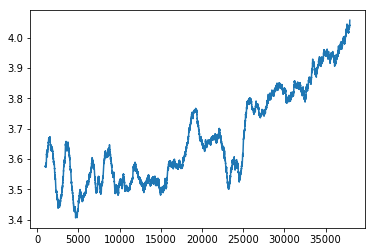

In [271]:
from pandas import rolling_mean, Series
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(rolling_mean(Series(star_ratings), 1000))

Once you've found a good value of `n_neighbors`, submit the model to the grader.  (*N.B.* "Good" is a relative measure here.  The reference solution has a r-squared value of only 0.02.  There is just rather little signal available for modeling.)

In [45]:
#grader.score('ml__lat_long_model', est.predict)  # Edit to appropriate name

Your score:  1.12138626398


*Item for thought:* Why do we choose a non-linear model for this estimator?

*Extension:* Use a `sklearn.ensemble.RandomForestRegressor`, which is a more powerful non-linear model.  Can you get better performance with this than with the `KNeighborsRegressor`?

## category_model
While location is important, we could also try seeing how predictive the
venue's category is.  Build an estimator that considers only the categories.

The categories come as a list of strings, but the built-in estimators all need numeric input.  The standard way to deal with categorical features is **one-hot encoding**, also known as dummy variables.  In this approach, each category gets its own column in the feature matrix.  If the row has a given category, that column gets filled with a 1.  Otherwise, it is 0.

The `ColumnSelectTransformer` from the previous question can be used to extract the categories column as a list of strings.  Scikit Learn provides [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer), which takes in a list of dictionaries.  It creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it.  Missing keys are filled with zeros.  Therefore, we need only build a transformer that takes a list strings to a dictionary with keys given by those strings and values one.

In [336]:
data[0]

{u'attributes': {u'By Appointment Only': True},
 u'business_id': u'vcNAWiLM4dR7D2nwwJ7nCA',
 u'categories': [u'Doctors', u'Health & Medical'],
 u'city': u'Phoenix',
 u'full_address': u'4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018',
 u'hours': {u'Friday': {u'close': u'17:00', u'open': u'08:00'},
  u'Monday': {u'close': u'17:00', u'open': u'08:00'},
  u'Thursday': {u'close': u'17:00', u'open': u'08:00'},
  u'Tuesday': {u'close': u'17:00', u'open': u'08:00'},
  u'Wednesday': {u'close': u'17:00', u'open': u'08:00'}},
 u'latitude': 33.499313,
 u'longitude': -111.983758,
 u'name': u'Eric Goldberg, MD',
 u'neighborhoods': [],
 u'open': True,
 u'review_count': 7,
 u'stars': 3.5,
 u'state': u'AZ',
 u'type': u'business'}

In [46]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will come in as a list of lists of lists.  Return a list of
        # dictionaries corresponding to those inner lists.
        flat_list = [item for sublist in X for item in sublist]
        dic_list = []
        for i in range(0,len(flat_list)):
            dic = defaultdict(int)
            for e in flat_list[i]:
                dic[e] += 1
            dic_list.append(dic)
        return dic_list

In [48]:
##just to test
X = [[['a']], [['b', 'c']]]
flat_list = [item for sublist in X for item in sublist]

dic_list = []
for i in range(0,len(flat_list)):
    dic = defaultdict(int)
    for e in flat_list[i]:
        dic[e] += 1
    dic_list.append(dic)
    print dic
print dic_list

defaultdict(<type 'int'>, {'a': 1})
defaultdict(<type 'int'>, {'c': 1, 'b': 1})
[defaultdict(<type 'int'>, {'a': 1}), defaultdict(<type 'int'>, {'c': 1, 'b': 1})]


That should allow this to pass:

In [47]:
assert (DictEncoder().fit_transform([[['a']], [['b', 'c']]]) == [{'a': 1}, {'b': 1, 'c': 1}])

Set up a pipeline with your `ColumnSelectTransformer`, your `DictEncoder`, the `DictVectorizer`, and a regularized linear model, like `Ridge`, as the estimator.  This model will have a large number of features, one for each category, so there is a significant danger of overfitting.  Use cross validation to choose the best regularization parameter.

In [50]:
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer

In [57]:
cat_est = Pipeline([('ColumnSelectTransformer',ColumnSelectTransformer(['categories'])),
                 ('DictEncoder',DictEncoder()),
                 ('DictVectorizer',DictVectorizer()),   
                 ('Ridge',Ridge(alpha=1.0)) ])

cat_est.fit(data, star_ratings)
#cross_val_score(llest,data,star_ratings,scoring='mean_squared_error')
#cat_est.predict(test_data)

Pipeline(steps=[('ColumnSelectTransformer', ColumnSelectTransformer(col_names=['categories'])), ('DictEncoder', DictEncoder()), ('DictVectorizer', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('Ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [59]:
#grader.score('ml__category_model', cat_est.predict)  # Edit to appropriate name

Your score:  0.965084967324


*Extension:* Some categories (e.g. Restaurants) are not very specific.  Others (Japanese sushi) are much more so.  One way to deal with this is with an measure call term-frequency-inverse-document-frequency (TF-IDF).  Add in a `sklearn.feature_extraction.text.TfidfTransformer` between the `DictVectorizer` and the linear model, and see if that improves performance.

*Extension:* Can you beat the performance of the linear estimator with a
non-linear model?

## attribute_model
There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them with one-hot encoding.  The `DictVectorizer` can do this, but only once we've flattened the dictionary to a single level, like so:
```
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```

Build a custom transformer that flattens the attributes dictionary.  Place this in a pipeline with a `DictVectorizer` and a regressor.

You may find it difficult to find a single regressor that does well enough.  A common solution is to use a linear model to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit.  Build a residual estimator that takes as an argument two other estimators.  It should use the first to fit the raw data and the second to fit the residuals of the first.

In [139]:
import flatdict
class FlatDictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will come in as a list of Dictionaries. Returns a flattened list of
        # dictionaries.
        dict_list = []
        for i in range(len(X)):
            flat = flatdict.FlatDict(X[i]['attributes'],delimiter='_')
            dict_list.append(flat)
        return dict_list
        
 

In [143]:
attribute_est = Pipeline([
                 ('FlatDictEncoder',FlatDictEncoder()),
                 ('DictVectorizer',DictVectorizer()),   
                 ('ensemble', ensemble.RandomForestRegressor(min_samples_leaf=20))
])

attribute_est.fit(data, star_ratings)


Pipeline(steps=[('FlatDictEncoder', FlatDictEncoder()), ('DictVectorizer', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('ensemble', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
   ...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn import ensemble, neighbors
from sklearn.pipeline import FeatureUnion
from sklearn import datasets, linear_model

In [214]:
class EnsembleTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_estimator, residual_estimators):
        self.base_estimator = base_estimator
        self.residual_estimators = residual_estimators
    
    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        y_err = y - self.base_estimator.predict(X)
        for est in self.residual_estimators:
            est.fit(X, y_err)
        return self
    
    def transform(self, X):
        all_ests = [self.base_estimator] + list(self.residual_estimators)
        return np.array([est.predict(X) for est in all_ests][0]).T
    
    def predict(self, X):
        all_ests = [self.base_estimator] + list(self.residual_estimators)
        return np.array([est.predict(X) for est in all_ests][0]).T

In [215]:
ensemble_pipe = Pipeline([
                ('FlatDictEncoder',FlatDictEncoder()),
                ('DictVectorizer',DictVectorizer()),
                ('ensemble', EnsembleTransformer(
                linear_model.LinearRegression(),
                (neighbors.KNeighborsRegressor(n_neighbors=30),
                 ensemble.RandomForestRegressor(min_samples_leaf=20))))
    ])
ensemble_pipe.fit(data, star_ratings)

Pipeline(steps=[('FlatDictEncoder', FlatDictEncoder()), ('DictVectorizer', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('ensemble', EnsembleTransformer(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          resi...mators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))))])

In [217]:
grader.score('ml__attribute_model', attribute_est.predict)  # Edit to appropriate name

Your score:  0.937424100842


In [216]:
#grader.score('ml__attribute_model', ensemble_pipe.predict) 

Your score:  0.783057689461


## full_model
So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to an estimator, we will have to turn them into transformers.  (A pipeline can contain at most a single estimator.)  Build a custom `ModelTransformer` class that takes an estimator as an argument.  When `fit()` is called, the estimator should be fit.  When `transform()` is called, the estimator's `predict()` method should be called, and its results returned.

Note that the output of the `transform()` method should be a 2-D array with a single column, in order for it to work well with the Scikit Learn pipeline.  If you're using Numpy arrays, you can use `.reshape(-1, 1)` to create a column vector.  If you are just using Python lists, you will want a list of lists of single elements.

In [190]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
#     def transform(self, X):
#         all_ests = [self.base_estimator] + list(self.residual_estimators)
#         return np.array([est.predict(X) for est in all_ests]).T

    def __init__(self, estimator):
        # What needs to be done here?
        self.base_estimator = estimator
    
    def fit(self, X, y):
        # Fit the stored estimator.
        # Question: what should be returned?
        self.base_estimator.fit(X, y)
        return self
        
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.
        return np.array(self.base_estimator.predict(X)).reshape(-1, 1)

This should work as follows:

In [193]:
city_trans = EstimatorTransformer(city_est)
city_trans.fit(data, star_ratings)
assert ([r[0] for r in city_trans.transform(data[:5])]== city_est.predict(data[:5]))

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[FeatureUnion](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [194]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
        # FeatureUnions use the same syntax as Pipelines
        ('city_est',EstimatorTransformer(city_est)),
        ('attribute_est', EstimatorTransformer(attribute_est)),
         ('cat_est',EstimatorTransformer(cat_est)),
        ('knn_est', EstimatorTransformer(est))
    ])

This should return a feature matrix with four columns.

In [195]:
union.fit(data, star_ratings)
trans_data = union.transform(data[:10])
assert trans_data.shape == (10, 4)

In [196]:
trans_data[0]

array([ 3.67029039,  3.90401849,  3.33782108,  3.98275862])

Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [199]:
final_pipe = Pipeline([("features", union), 
                      ('ensemble', ensemble.RandomForestRegressor(min_samples_leaf=20))
                      ])

final_pipe.fit(data, star_ratings)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('city_est', EstimatorTransformer(estimator=None)), ('attribute_est', EstimatorTransformer(estimator=None)), ('cat_est', EstimatorTransformer(estimator=None)), ('knn_est', EstimatorTransformer(estimator=None))],
       transformer_w...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [200]:
#grader.score('ml__full_model', final_pipe.predict)  # Edit to appropriate name

Your score:  0.948712129111


*Extension:* By combining our models with a linear model, we will be unable to notice any correlation between features.  We don't expect all attributes to have the same effect on all venues.  For example, "Ambiance: divey" might be a bad indicator for a restaurant but a good one for a bar.  Nonlinear models can pick up on this interaction.  Replace the linear model combining the predictions with a nonlinear one like [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).  Better yet, use the nonlinear model to fit the residuals of the linear model.

The score for this question is just a ratio of the score of your model to the score of a reference solution.  Can you beat the reference solution and get a score greater than 1.0?

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*

In [103]:
class InnerDictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will come in as a list of Dictionaries. Returns a flattened list of
        # dictionaries.
        
        #flat_list = [item for item in X for item in sublist]
        dict_list = []

        dict_flattened = defaultdict(int)

        for e in X:
            #print e
            for key, value in e[0].items():
                if isinstance(e[0][key],dict):    
                    for k, v in e[0][key].items():
                        a = key + '_' + str(k)
                        b = int(v)
                        dict_flattened[a]=b

                else:
                    if isinstance(value,bool):
                        a = key 
                        dict_flattened[a]=int(value)
                    else:
                        a = key + '_'+str(value)
                        if isinstance(value,str):
                            dict_flattened[a]=1
                        else:
                            dict_flattened[a]=int(value)
            dict_list.append(dict_flattened)
        return dict_list